In [12]:
import os
import pickle
import sncosmo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
from sfdmap import SFDMap
from collections import defaultdict
from astropy.io import ascii

In [13]:
def modify_error(lc, error_floor=0.):
    """Add an error floor of `error_floor` times the maximum flux of the band
    to each observation
    """
    data = sncosmo.photdata.photometric_data(lc).normalized(zp=25., zpsys='ab')
    new_lc = {'time': data.time,
              'band': data.band,
              'flux': data.flux,
              'fluxerr': data.fluxerr,
              'zp': data.zp,
              'zpsys': data.zpsys}
    for band in set(data.band):
        band_cut = data.band==band
        max_flux_in_band = np.max(data.flux[band_cut])
        new_lc['fluxerr'][band_cut] = np.sqrt((error_floor*max_flux_in_band)**2+data.fluxerr[band_cut]**2)
    new_lc = Table(new_lc, meta=lc.meta)   
    return new_lc

def phase_and_wave_mask(data, model, t0, z, phase_range):
    """Return a mask for the data based on an allowed rest-frame phase and/or
    wavelength range (given some t0 and z)."""
    data_phase = (data['time'] - t0) / (1.0 + z)
    phase_mask = ((data_phase > phase_range[0]) &
                      (data_phase < phase_range[1]))

    wave_mask = np.array([model.bandoverlap(b) for b in data['band']])
    return phase_mask & wave_mask

In [14]:
result_dir = 'results_mw_reddening_mcmc/'

# JLA fits

In [15]:
data_dir = '/home/samdixon/jla_light_curves/'

In [59]:
def jla_chisq(result_path):
    res = pickle.load(open(result_path, 'rb'))
    err_floor = int(result_path.split('/')[-2].split('_')[-1])/100
    model_name = result_path.split('/')[-2].split('_')[-2]
    model = sncosmo.Model(source=model_name,
                          effects=[sncosmo.CCM89Dust()],
                          effect_names=['mw'],
                          effect_frames=['obs'])
    model.set(**dict(zip(res['param_names'], res['parameters'])))
    name = file.split('.')[0]
    try:
        _ = int(name)
        name = 'lc-SDSS{}.list'.format(name)
    except:
        name = 'lc-{}.list'.format(name)
    lc_path = os.path.join('/home/samdixon/jla_light_curves/', name)
    lc = sncosmo.read_lc(lc_path, format='salt2', expand_bands=True, read_covmat=True)
    lc = modify_error(lc, err_floor)
    z, t0 = model.parameters[:2]
    phase_range = (-15, 45) if model_name=='salt2' else (-10, 40)
    mask = phase_and_wave_mask(lc, model, t0, z, phase_range)
    lc = lc[mask]
    model_flux = model.bandflux(lc['band'], lc['time'], lc['zp'], lc['zpsys'])
    if res['ndof'] <= 1:
        return np.nan
    return np.sum((model_flux-lc['flux'])**2/lc['fluxerr']**2)/(res['ndof'])

(array([  2.,   5.,  81., 302., 199.,  81.,  32.,  11.,   6.,   4.]),
 array([-1.02715807, -0.75174816, -0.47633825, -0.20092834,  0.07448157,
         0.34989149,  0.6253014 ,  0.90071131,  1.17612122,  1.45153113,
         1.72694105]),
 <a list of 10 Patch objects>)

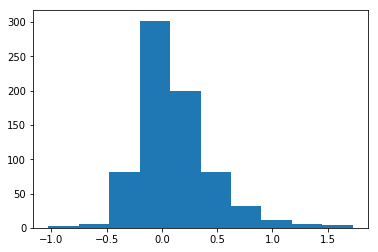

In [60]:
model_name = 'snemo2'
err = 2
survey = 'jla'
subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))

jla_chisqs = []
for file in os.listdir(subdir):
    result_path = os.path.join(subdir, file)
    jla_chisqs.append(jla_chisq(result_path))
jla_chisqs = np.array(jla_chisqs)
plt.hist(np.log10(jla_chisqs[np.isfinite(jla_chisqs)]))

# CSP

In [61]:
data_dir = '/home/samdixon/CSP_Photometry_DR3/'

In [65]:
CSP_FILT_MAP = {'u': 'cspu',
                'g': 'cspg',
                'r': 'cspr',
                'i': 'cspi',
                'B': 'cspb',
                'V0': 'cspv3014',
                'V1': 'cspv3009',
                'V': 'cspv9844',
                'Y': 'cspys',
                'H': 'csphs',
                'J': 'cspjs',
                'Jrc2': 'cspjs',
                'Ydw': 'cspyd',
                'Jdw': 'cspjd',
                'Hdw': 'csphd'}
MAGSYS = sncosmo.get_magsystem('csp')

MWDUSTMAP = SFDMap('/home/samdixon/sfddata/')

def parse_csp_lc(path):
    meta = {}
    lc = defaultdict(list)
    current_filt = None
    with open(path) as f:
        for l in f.readlines():
            if l.split()[0][:2]=='SN':
                name, z, ra, dec = l.split()
                meta['name'] = name.strip()
                meta['z'] = float(z.strip())
                meta['mwebv'] = MWDUSTMAP.ebv(float(ra), float(dec))
                continue
            if l.split()[0] == 'filter':
                current_filt = CSP_FILT_MAP[l.split()[-1]]
            else:
                time, mag, mag_err = [float(x.strip()) for x in l.split()]
                flux = MAGSYS.band_mag_to_flux(mag, current_filt)
                flux_err = mag_err*flux*np.log(10)/2.5
                lc['time'].append(53000 + time)
                lc['flux'].append(flux)
                lc['flux_err'].append(flux_err)
                lc['zp'].append(2.5*np.log10(MAGSYS.zpbandflux(current_filt)))
                lc['zpsys'].append('csp')
                lc['band'].append(current_filt)
    return Table(lc, meta=meta)

def csp_chisq(result_path):
    res = pickle.load(open(result_path, 'rb'))
    err_floor = int(result_path.split('/')[-2].split('_')[-1])/100
    model_name = result_path.split('/')[-2].split('_')[-2]
    model = sncosmo.Model(source=model_name,
                          effects=[sncosmo.CCM89Dust()],
                          effect_names=['mw'],
                          effect_frames=['obs'])
    model.set(**dict(zip(res['param_names'], res['parameters'])))
    name = '{}_snpy.txt'.format(file.split('.')[0])
    lc_path = os.path.join(data_dir, name)
    lc = parse_csp_lc(lc_path)
    lc = modify_error(lc, err_floor)
    z, t0 = model.parameters[:2]
    phase_range = (-15, 45) if model_name=='salt2' else (-10, 40)
    mask = phase_and_wave_mask(lc, model, t0, z, phase_range)
    lc = lc[mask]
    model_flux = model.bandflux(lc['band'], lc['time'], lc['zp'], lc['zpsys'])
    if res['ndof'] <= 1:
        return np.nan
    return np.sum((model_flux-lc['flux'])**2/lc['fluxerr']**2)/(res['ndof'])

(array([11., 16., 21., 25., 21., 10., 14.,  8.,  4.,  3.]),
 array([-0.41823905, -0.17181261,  0.07461382,  0.32104026,  0.5674667 ,
         0.81389313,  1.06031957,  1.306746  ,  1.55317244,  1.79959887,
         2.04602531]),
 <a list of 10 Patch objects>)

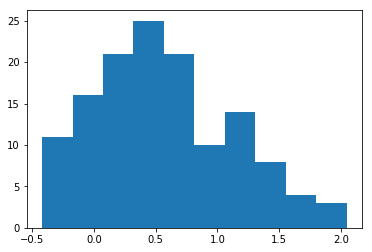

In [66]:
model_name = 'snemo2'
err = 2
survey = 'csp'
subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))

csp_chisqs = []
for file in os.listdir(subdir):
    result_path = os.path.join(subdir, file)
    csp_chisqs.append(csp_chisq(result_path))
csp_chisqs = np.array(csp_chisqs)
plt.hist(np.log10(csp_chisqs[np.isfinite(csp_chisqs)]))

# Foundation

In [68]:
DATA = pd.read_csv('/home/samdixon/foundation_photometry.txt', delimiter=', ', engine='python')
META = ascii.read('/home/samdixon/foundation_lc_params.tex', format='latex').to_pandas()
META = META.set_index('SN')
HOSTDATA = pd.read_csv('/home/samdixon/host_unity/fitting/gupta_host.txt', delim_whitespace=True)
HOSTDATA = HOSTDATA.set_index('name')

SCRIPT_DIR = 'scripts'
if not os.path.isdir(SCRIPT_DIR):
    os.makedirs(SCRIPT_DIR)
    
TEMPLATE = """#!/bin/bash
#$ -N mcmc_ps_{}_{}
#$ -cwd

/home/samdixon/miniconda3/bin/python /home/samdixon/host_unity/mcmc_lc_foundation_fit.py {} {}"""

TEMPLATE_ERR = """#!/bin/bash
#$ -N mcmc_ps_{:02d}_{}_{}
#$ -cwd

/home/samdixon/miniconda3/bin/python /home/samdixon/host_unity/mcmc_lc_foundation_fit.py {} {} {}"""

PS_FILTS = ascii.read('/home/samdixon/PSfilters.txt')

def read_and_register(name):
    name = name.lower()
    wave = PS_FILTS['Wave']*10
    trans = PS_FILTS[name]
    band = sncosmo.Bandpass(wave=wave, trans=trans, name=name)
    sncosmo.register(band, force=True)

for filt in DATA['Filter'].unique():
        read_and_register(filt)
    
def get_foundation_lc(sn_name):
    sn_data = DATA[DATA['SN'] == sn_name]
    meta_data = META.loc[sn_name]
    host = HOSTDATA[HOSTDATA.index.str.contains(sn_name)]
    mwebv = host['MW_EBV'][0]
    meta = {'name': sn_name,
            'z': float(meta_data['z_helio'].split()[0]),
            't0': float(meta_data['Peak_MJD'].split()[0]),
            'mwebv': mwebv}
    lc = {'time': sn_data['MJD'],
          'band': sn_data['Filter'],
          'flux': sn_data['Flux'],
          'flux_err': sn_data['Flux_Uncertainty'],
          'zp': [27.5 for x in range(len(sn_data))],
          'zpsys': ['ab' for x in range(len(sn_data))]}
    return Table(lc, meta=meta)

def ps_chisq(result_path):
    res = pickle.load(open(result_path, 'rb'))
    err_floor = int(result_path.split('/')[-2].split('_')[-1])/100
    model_name = result_path.split('/')[-2].split('_')[-2]
    model = sncosmo.Model(source=model_name,
                          effects=[sncosmo.CCM89Dust()],
                          effect_names=['mw'],
                          effect_frames=['obs'])
    model.set(**dict(zip(res['param_names'], res['parameters'])))
    
    name = file.split('.')[0]
    lc = get_foundation_lc(name)
    lc = modify_error(lc, err_floor)
    
    z, t0 = model.parameters[:2]
    phase_range = (-15, 45) if model_name=='salt2' else (-10, 40)
    mask = phase_and_wave_mask(lc, model, t0, z, phase_range)
    lc = lc[mask]
    model_flux = model.bandflux(lc['band'], lc['time'], lc['zp'], lc['zpsys'])
    if res['ndof'] <= 1:
        return np.nan
    return np.sum((model_flux-lc['flux'])**2/lc['fluxerr']**2)/(res['ndof'])

(array([ 1., 10.,  9., 10.,  6.,  1.,  3.,  2.,  0.,  2.]),
 array([-0.20895512, -0.09057636,  0.0278024 ,  0.14618116,  0.26455992,
         0.38293868,  0.50131743,  0.61969619,  0.73807495,  0.85645371,
         0.97483247]),
 <a list of 10 Patch objects>)

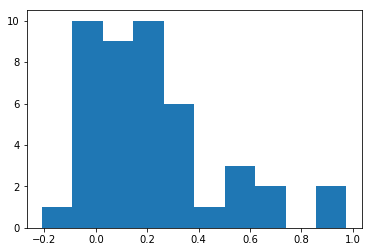

In [70]:
model_name = 'snemo7'
err = 2
survey = 'ps'
subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))

ps_chisqs = []
for file in os.listdir(subdir):
    result_path = os.path.join(subdir, file)
    ps_chisqs.append(ps_chisq(result_path))
ps_chisqs = np.array(ps_chisqs)
plt.hist(np.log10(ps_chisqs[np.isfinite(ps_chisqs)]))

# Combined

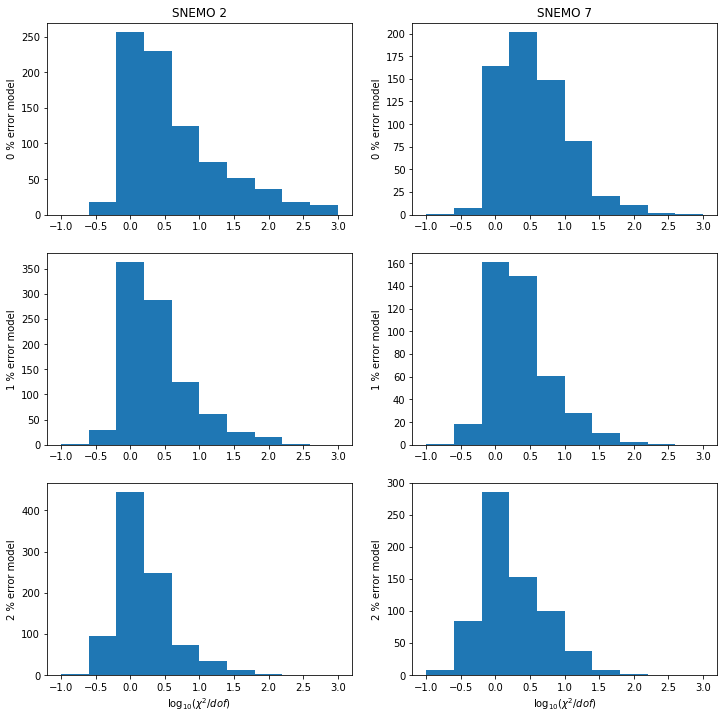

In [74]:
plt.figure(figsize=(12, 12))

for err in range(3):
    model_name = 'snemo2'
    plt.subplot(3, 2, 2*err+1)
    if err==0:
        plt.title('SNEMO 2')
    chisqs = []
    survey = 'jla'
    subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))
    for file in os.listdir(subdir):
        result_path = os.path.join(subdir, file)
        chisqs.append(jla_chisq(result_path))
    
    survey = 'csp'
    subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))
    for file in os.listdir(subdir):
        result_path = os.path.join(subdir, file)
        chisqs.append(csp_chisq(result_path))
    
    survey = 'ps'
    subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))
    for file in os.listdir(subdir):
        result_path = os.path.join(subdir, file)
        chisqs.append(ps_chisq(result_path))
    chisqs = np.array(chisqs)
    plt.hist(np.log10(chisqs[np.isfinite(chisqs)]),
             range=(-1, 3))
    plt.ylabel('{} % error model'.format(err))
    if err==2:
        plt.xlabel('$\log_{10}(\chi^2/dof)$')
        
    model_name = 'snemo7'
    plt.subplot(3, 2, 2*err+2)
    if err==0:
        plt.title('SNEMO 7')
    chisqs = []
    survey = 'jla'
    subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))
    for file in os.listdir(subdir):
        result_path = os.path.join(subdir, file)
        chisqs.append(jla_chisq(result_path))
    
    survey = 'csp'
    subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))
    for file in os.listdir(subdir):
        result_path = os.path.join(subdir, file)
        chisqs.append(csp_chisq(result_path))
    
    survey = 'ps'
    subdir = os.path.join(result_dir, '{}_{}_{:02d}'.format(survey, model_name, err))
    for file in os.listdir(subdir):
        result_path = os.path.join(subdir, file)
        chisqs.append(ps_chisq(result_path))
    chisqs = np.array(chisqs)
    plt.hist(np.log10(chisqs[np.isfinite(chisqs)]),
             range=(-1, 3))
    plt.ylabel('{} % error model'.format(err))
    if err==2:
        plt.xlabel('$\log_{10}(\chi^2/dof)$')